In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 128

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = Dropout(0.5)(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 128)   768         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 128)   0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPoo

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 128)   768         input_3[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 128)   0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 5333, 128)    0           activation_7[0][0]               
__________________________________________________________________________________________________
conv1d_8 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 128)   768         input_5[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 128)   0           conv1d_18[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_18 (MaxPooling1D) (None, 5333, 128)    0           activation_18[0][0]              
__________________________________________________________________________________________________
conv1d_19 

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6642 - acc: 0.1377
Epoch 00001: val_loss improved from inf to 2.47907, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/001-2.4791.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 2.6642 - acc: 0.1376 - val_loss: 2.4791 - val_acc: 0.2409
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3718 - acc: 0.2324
Epoch 00002: val_loss improved from 2.47907 to 2.16337, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/002-2.1634.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 2.3719 - acc: 0.2324 - val_loss: 2.1634 - val_acc: 0.3149
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1835 - acc: 0.2731
Epoch 00003: val_loss improved from 2.16337 t

Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4229 - acc: 0.5523
Epoch 00022: val_loss improved from 1.25495 to 1.24108, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/022-1.2411.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.4228 - acc: 0.5523 - val_loss: 1.2411 - val_acc: 0.6310
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4051 - acc: 0.5574
Epoch 00023: val_loss improved from 1.24108 to 1.22140, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/023-1.2214.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.4051 - acc: 0.5575 - val_loss: 1.2214 - val_acc: 0.6401
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3842 - acc: 0.5673
Epoch 00024: val_loss improved from 1.22140 to 1.20995, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_che

36800/36805 [============================>.] - ETA: 0s - loss: 1.1494 - acc: 0.6483
Epoch 00043: val_loss improved from 0.97873 to 0.96153, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/043-0.9615.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.1495 - acc: 0.6482 - val_loss: 0.9615 - val_acc: 0.7193
Epoch 44/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1441 - acc: 0.6490
Epoch 00044: val_loss improved from 0.96153 to 0.95485, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/044-0.9548.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.1441 - acc: 0.6490 - val_loss: 0.9548 - val_acc: 0.7200
Epoch 45/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1317 - acc: 0.6532
Epoch 00045: val_loss improved from 0.95485 to 0.95383, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/045-0

Epoch 66/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0226 - acc: 0.6948
Epoch 00066: val_loss did not improve from 0.83418
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.0225 - acc: 0.6948 - val_loss: 0.8385 - val_acc: 0.7624
Epoch 67/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0207 - acc: 0.6935
Epoch 00067: val_loss improved from 0.83418 to 0.83323, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/067-0.8332.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.0206 - acc: 0.6935 - val_loss: 0.8332 - val_acc: 0.7638
Epoch 68/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0156 - acc: 0.6938
Epoch 00068: val_loss improved from 0.83323 to 0.82847, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/068-0.8285.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 1.0155 - acc: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.9474 - acc: 0.7174
Epoch 00089: val_loss improved from 0.77294 to 0.76545, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/089-0.7655.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.9474 - acc: 0.7175 - val_loss: 0.7655 - val_acc: 0.7848
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9454 - acc: 0.7180
Epoch 00090: val_loss did not improve from 0.76545
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.9454 - acc: 0.7180 - val_loss: 0.7665 - val_acc: 0.7883
Epoch 91/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9406 - acc: 0.7213- ETA: 0s - loss: 0.9425 - ac
Epoch 00091: val_loss did not improve from 0.76545
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.9406 - acc: 0.7213 - val_loss: 0.7684 - val_acc: 0.7806
Epoch 92/500
36800/36805 [======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.8963 - acc: 0.7346
Epoch 00115: val_loss improved from 0.71732 to 0.71013, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/115-0.7101.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8962 - acc: 0.7346 - val_loss: 0.7101 - val_acc: 0.8085
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8916 - acc: 0.7371
Epoch 00116: val_loss did not improve from 0.71013
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8916 - acc: 0.7371 - val_loss: 0.7190 - val_acc: 0.7971
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8909 - acc: 0.7356
Epoch 00117: val_loss improved from 0.71013 to 0.70971, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/117-0.7097.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8909 - acc: 0.7356 - va

36800/36805 [============================>.] - ETA: 0s - loss: 0.8557 - acc: 0.7449
Epoch 00141: val_loss did not improve from 0.67495
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8556 - acc: 0.7449 - val_loss: 0.6787 - val_acc: 0.8150
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8561 - acc: 0.7477
Epoch 00142: val_loss did not improve from 0.67495
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8561 - acc: 0.7477 - val_loss: 0.6768 - val_acc: 0.8157
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8553 - acc: 0.7465
Epoch 00143: val_loss did not improve from 0.67495
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8553 - acc: 0.7464 - val_loss: 0.6861 - val_acc: 0.8116
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8554 - acc: 0.7477
Epoch 00144: val_loss improved from 0.67495 to 0.67039, saving model to model/checkpo

36800/36805 [============================>.] - ETA: 0s - loss: 0.8312 - acc: 0.7529
Epoch 00167: val_loss did not improve from 0.65032
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8312 - acc: 0.7528 - val_loss: 0.6521 - val_acc: 0.8195
Epoch 168/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8280 - acc: 0.7560
Epoch 00168: val_loss improved from 0.65032 to 0.64682, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/168-0.6468.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8280 - acc: 0.7560 - val_loss: 0.6468 - val_acc: 0.8290
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8313 - acc: 0.7557
Epoch 00169: val_loss did not improve from 0.64682
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8314 - acc: 0.7557 - val_loss: 0.6468 - val_acc: 0.8251
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.8109 - acc: 0.7607
Epoch 00193: val_loss did not improve from 0.62459
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8109 - acc: 0.7607 - val_loss: 0.6324 - val_acc: 0.8267
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8025 - acc: 0.7622
Epoch 00194: val_loss did not improve from 0.62459
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8025 - acc: 0.7622 - val_loss: 0.6256 - val_acc: 0.8318
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8046 - acc: 0.7644
Epoch 00195: val_loss improved from 0.62459 to 0.62260, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/195-0.6226.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.8046 - acc: 0.7644 - val_loss: 0.6226 - val_acc: 0.8304
Epoch 196/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 221/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7871 - acc: 0.7670
Epoch 00221: val_loss improved from 0.61110 to 0.60707, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/221-0.6071.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7871 - acc: 0.7670 - val_loss: 0.6071 - val_acc: 0.8404
Epoch 222/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7831 - acc: 0.7719
Epoch 00222: val_loss did not improve from 0.60707
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7831 - acc: 0.7719 - val_loss: 0.6154 - val_acc: 0.8355
Epoch 223/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7839 - acc: 0.7711
Epoch 00223: val_loss did not improve from 0.60707
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7839 - acc: 0.7711 - val_loss: 0.6152 - val_acc: 0.8344
Epoch 224/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.7648 - acc: 0.7745
Epoch 00248: val_loss did not improve from 0.59293
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7647 - acc: 0.7745 - val_loss: 0.5995 - val_acc: 0.8428
Epoch 249/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7699 - acc: 0.7736
Epoch 00249: val_loss did not improve from 0.59293
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7699 - acc: 0.7736 - val_loss: 0.6006 - val_acc: 0.8416
Epoch 250/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7617 - acc: 0.7770
Epoch 00250: val_loss did not improve from 0.59293
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7616 - acc: 0.7770 - val_loss: 0.5996 - val_acc: 0.8365
Epoch 251/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7651 - acc: 0.7750
Epoch 00251: val_loss did not improve from 0.59293
36805/36805 [=====================

Epoch 276/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7521 - acc: 0.7793
Epoch 00276: val_loss did not improve from 0.58162
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7522 - acc: 0.7793 - val_loss: 0.5854 - val_acc: 0.8444
Epoch 277/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7456 - acc: 0.7789
Epoch 00277: val_loss did not improve from 0.58162
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7457 - acc: 0.7788 - val_loss: 0.5911 - val_acc: 0.8444
Epoch 278/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7541 - acc: 0.7785
Epoch 00278: val_loss did not improve from 0.58162
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7541 - acc: 0.7785 - val_loss: 0.6039 - val_acc: 0.8435
Epoch 279/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7507 - acc: 0.7797
Epoch 00279: val_loss did not improve from 0.58162
36805/36805 [=======

Epoch 304/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7347 - acc: 0.7830
Epoch 00304: val_loss did not improve from 0.57135
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7346 - acc: 0.7830 - val_loss: 0.5727 - val_acc: 0.8512
Epoch 305/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7383 - acc: 0.7831
Epoch 00305: val_loss improved from 0.57135 to 0.57032, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/305-0.5703.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7383 - acc: 0.7831 - val_loss: 0.5703 - val_acc: 0.8505
Epoch 306/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7358 - acc: 0.7845
Epoch 00306: val_loss did not improve from 0.57032
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7358 - acc: 0.7845 - val_loss: 0.5776 - val_acc: 0.8498
Epoch 307/500
36800/36805 [============================>.] - 

Epoch 331/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7273 - acc: 0.7872
Epoch 00331: val_loss did not improve from 0.55993
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7273 - acc: 0.7872 - val_loss: 0.5625 - val_acc: 0.8563
Epoch 332/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7237 - acc: 0.7874
Epoch 00332: val_loss improved from 0.55993 to 0.55802, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/332-0.5580.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7236 - acc: 0.7874 - val_loss: 0.5580 - val_acc: 0.8535
Epoch 333/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7257 - acc: 0.7871
Epoch 00333: val_loss did not improve from 0.55802
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7256 - acc: 0.7871 - val_loss: 0.5687 - val_acc: 0.8507
Epoch 334/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.7142 - acc: 0.7901- ETA: 2s 
Epoch 00359: val_loss did not improve from 0.55323
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7142 - acc: 0.7901 - val_loss: 0.5685 - val_acc: 0.8495
Epoch 360/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7079 - acc: 0.7928
Epoch 00360: val_loss did not improve from 0.55323
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7078 - acc: 0.7929 - val_loss: 0.5558 - val_acc: 0.8514
Epoch 361/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7132 - acc: 0.7904
Epoch 00361: val_loss did not improve from 0.55323
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7133 - acc: 0.7904 - val_loss: 0.5579 - val_acc: 0.8519
Epoch 362/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7148 - acc: 0.7882
Epoch 00362: val_loss did not improve from 0.55323
36805/36805 [===========

Epoch 388/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7032 - acc: 0.7951
Epoch 00388: val_loss did not improve from 0.54772
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.7034 - acc: 0.7950 - val_loss: 0.5506 - val_acc: 0.8514
Epoch 389/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6982 - acc: 0.7930
Epoch 00389: val_loss did not improve from 0.54772
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6982 - acc: 0.7930 - val_loss: 0.5595 - val_acc: 0.8477
Epoch 390/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6994 - acc: 0.7932
Epoch 00390: val_loss did not improve from 0.54772
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6994 - acc: 0.7932 - val_loss: 0.5506 - val_acc: 0.8567
Epoch 391/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7033 - acc: 0.7929
Epoch 00391: val_loss improved from 0.54772 to 0.54603, saving model to

36800/36805 [============================>.] - ETA: 0s - loss: 0.6908 - acc: 0.7952
Epoch 00415: val_loss improved from 0.53868 to 0.53817, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv_checkpoint/415-0.5382.hdf5
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6908 - acc: 0.7952 - val_loss: 0.5382 - val_acc: 0.8572
Epoch 416/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6905 - acc: 0.7955
Epoch 00416: val_loss did not improve from 0.53817
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6904 - acc: 0.7955 - val_loss: 0.5500 - val_acc: 0.8539
Epoch 417/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6907 - acc: 0.7981- ETA: 1s - loss: 0.69
Epoch 00417: val_loss did not improve from 0.53817
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6907 - acc: 0.7982 - val_loss: 0.5440 - val_acc: 0.8607
Epoch 418/500
36800/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.6856 - acc: 0.7964
Epoch 00443: val_loss did not improve from 0.53275
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6856 - acc: 0.7964 - val_loss: 0.5465 - val_acc: 0.8558
Epoch 444/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6860 - acc: 0.7971
Epoch 00444: val_loss did not improve from 0.53275
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6859 - acc: 0.7971 - val_loss: 0.5387 - val_acc: 0.8584
Epoch 445/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6872 - acc: 0.7976
Epoch 00445: val_loss did not improve from 0.53275
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6875 - acc: 0.7975 - val_loss: 0.5334 - val_acc: 0.8623
Epoch 446/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6820 - acc: 0.7969
Epoch 00446: val_loss did not improve from 0.53275
36805/36805 [=====================

Epoch 471/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6797 - acc: 0.8015
Epoch 00471: val_loss did not improve from 0.52904
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6797 - acc: 0.8016 - val_loss: 0.5414 - val_acc: 0.8581
Epoch 472/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6760 - acc: 0.7986
Epoch 00472: val_loss did not improve from 0.52904
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6759 - acc: 0.7986 - val_loss: 0.5336 - val_acc: 0.8616
Epoch 473/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6846 - acc: 0.7994
Epoch 00473: val_loss did not improve from 0.52904
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6846 - acc: 0.7994 - val_loss: 0.5389 - val_acc: 0.8612
Epoch 474/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6754 - acc: 0.8016
Epoch 00474: val_loss did not improve from 0.52904
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.6640 - acc: 0.8053
Epoch 00499: val_loss did not improve from 0.52521
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6640 - acc: 0.8053 - val_loss: 0.5284 - val_acc: 0.8633
Epoch 500/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6691 - acc: 0.8035
Epoch 00500: val_loss did not improve from 0.52521
36805/36805 [==============================] - 60s 2ms/sample - loss: 0.6690 - acc: 0.8035 - val_loss: 0.5329 - val_acc: 0.8602

1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv Model


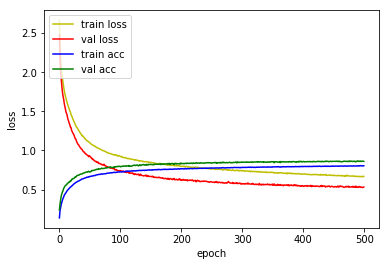

4815/4815 [==============================] - 3s 653us/sample - loss: 0.6031 - acc: 0.8297
Loss: 0.6031385346736492 Accuracy: 0.82969886

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5137 - acc: 0.1822
Epoch 00001: val_loss improved from inf to 2.08777, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/001-2.0878.hdf5
36805/36805 [==============================] - 63s 2ms/sample - loss: 2.5137 - acc: 0.1823 - val_loss: 2.0878 - val_acc: 0.3361
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0829 - acc: 0.3087
Epoch 00002: val_loss improved from 2.08777 to 1.84638, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/002-1.8464.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 2.0829 - acc: 0.3087 - val_loss: 1.8464 - val_acc: 0.4253
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 1.0462 - acc: 0.6765
Epoch 00022: val_loss improved from 0.88716 to 0.86600, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/022-0.8660.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.0461 - acc: 0.6765 - val_loss: 0.8660 - val_acc: 0.7466
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0325 - acc: 0.6801
Epoch 00023: val_loss improved from 0.86600 to 0.84959, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/023-0.8496.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.0325 - acc: 0.6801 - val_loss: 0.8496 - val_acc: 0.7540
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0092 - acc: 0.6879
Epoch 00024: val_loss improved from 0.84959 to 0.84065, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/024-0

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8061 - acc: 0.7592
Epoch 00046: val_loss did not improve from 0.67108
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.8062 - acc: 0.7592 - val_loss: 0.6841 - val_acc: 0.8104
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8021 - acc: 0.7594
Epoch 00047: val_loss improved from 0.67108 to 0.65425, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/047-0.6543.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.8022 - acc: 0.7593 - val_loss: 0.6543 - val_acc: 0.8232
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7930 - acc: 0.7641
Epoch 00048: val_loss did not improve from 0.65425
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.7930 - acc: 0.7641 - val_loss: 0.6703 - val_acc: 0.8137
Epoch 49/500
36800/36805 [============================>.] - ETA:

Epoch 70/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7066 - acc: 0.7923
Epoch 00070: val_loss did not improve from 0.57526
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.7065 - acc: 0.7923 - val_loss: 0.5796 - val_acc: 0.8477
Epoch 71/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6989 - acc: 0.7927
Epoch 00071: val_loss did not improve from 0.57526
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.6989 - acc: 0.7927 - val_loss: 0.5753 - val_acc: 0.8477
Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6957 - acc: 0.7958
Epoch 00072: val_loss improved from 0.57526 to 0.56705, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/072-0.5671.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.6957 - acc: 0.7957 - val_loss: 0.5671 - val_acc: 0.8472
Epoch 73/500
36800/36805 [============================>.] - ETA:

Epoch 96/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6259 - acc: 0.8193
Epoch 00096: val_loss did not improve from 0.51416
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.6258 - acc: 0.8193 - val_loss: 0.5162 - val_acc: 0.8640
Epoch 97/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6175 - acc: 0.8189
Epoch 00097: val_loss improved from 0.51416 to 0.51173, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/097-0.5117.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.6176 - acc: 0.8189 - val_loss: 0.5117 - val_acc: 0.8633
Epoch 98/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6115 - acc: 0.8201
Epoch 00098: val_loss improved from 0.51173 to 0.50502, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/098-0.5050.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.6115 - acc: 

Epoch 121/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5687 - acc: 0.8347
Epoch 00121: val_loss did not improve from 0.46767
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.5687 - acc: 0.8346 - val_loss: 0.4764 - val_acc: 0.8754
Epoch 122/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5670 - acc: 0.8346
Epoch 00122: val_loss did not improve from 0.46767
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.5670 - acc: 0.8346 - val_loss: 0.4682 - val_acc: 0.8772
Epoch 123/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5602 - acc: 0.8372
Epoch 00123: val_loss did not improve from 0.46767
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.5602 - acc: 0.8372 - val_loss: 0.4832 - val_acc: 0.8654
Epoch 124/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5562 - acc: 0.8372
Epoch 00124: val_loss improved from 0.46767 to 0.45938, saving model to

Epoch 148/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5169 - acc: 0.8494
Epoch 00148: val_loss did not improve from 0.43740
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.5169 - acc: 0.8494 - val_loss: 0.4375 - val_acc: 0.8807
Epoch 149/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5156 - acc: 0.8489
Epoch 00149: val_loss did not improve from 0.43740
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.5157 - acc: 0.8489 - val_loss: 0.4432 - val_acc: 0.8810
Epoch 150/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5180 - acc: 0.8511
Epoch 00150: val_loss improved from 0.43740 to 0.43139, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/150-0.4314.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.5179 - acc: 0.8512 - val_loss: 0.4314 - val_acc: 0.8842
Epoch 151/500
36800/36805 [============================>.] - 

Epoch 175/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4717 - acc: 0.8632
Epoch 00175: val_loss did not improve from 0.41046
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4717 - acc: 0.8633 - val_loss: 0.4206 - val_acc: 0.8868
Epoch 176/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4703 - acc: 0.8622
Epoch 00176: val_loss did not improve from 0.41046
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4703 - acc: 0.8622 - val_loss: 0.4181 - val_acc: 0.8849
Epoch 177/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4753 - acc: 0.8609
Epoch 00177: val_loss improved from 0.41046 to 0.40969, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/177-0.4097.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4753 - acc: 0.8609 - val_loss: 0.4097 - val_acc: 0.8910
Epoch 178/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.4338 - acc: 0.8738
Epoch 00202: val_loss improved from 0.38903 to 0.38870, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/202-0.3887.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4338 - acc: 0.8737 - val_loss: 0.3887 - val_acc: 0.8994
Epoch 203/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4323 - acc: 0.8743
Epoch 00203: val_loss improved from 0.38870 to 0.38800, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/203-0.3880.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4323 - acc: 0.8743 - val_loss: 0.3880 - val_acc: 0.8961
Epoch 204/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4376 - acc: 0.8712
Epoch 00204: val_loss did not improve from 0.38800
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4376 - acc: 0.8712 - va

36800/36805 [============================>.] - ETA: 0s - loss: 0.4058 - acc: 0.8788
Epoch 00230: val_loss improved from 0.37905 to 0.37794, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_4_conv_checkpoint/230-0.3779.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4058 - acc: 0.8788 - val_loss: 0.3779 - val_acc: 0.9005
Epoch 231/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4076 - acc: 0.8788
Epoch 00231: val_loss did not improve from 0.37794
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4075 - acc: 0.8788 - val_loss: 0.3873 - val_acc: 0.8991
Epoch 232/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4060 - acc: 0.8797
Epoch 00232: val_loss did not improve from 0.37794
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.4060 - acc: 0.8797 - val_loss: 0.3951 - val_acc: 0.8977
Epoch 233/500
36800/36805 [============================>.] - ETA: 0s - loss

36800/36805 [============================>.] - ETA: 0s - loss: 0.3867 - acc: 0.8864
Epoch 00257: val_loss did not improve from 0.36627
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3867 - acc: 0.8864 - val_loss: 0.3699 - val_acc: 0.9033
Epoch 258/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3803 - acc: 0.8867
Epoch 00258: val_loss did not improve from 0.36627
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3803 - acc: 0.8868 - val_loss: 0.3762 - val_acc: 0.9061
Epoch 259/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3770 - acc: 0.8883
Epoch 00259: val_loss did not improve from 0.36627
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3770 - acc: 0.8883 - val_loss: 0.3734 - val_acc: 0.9036
Epoch 260/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3759 - acc: 0.8895
Epoch 00260: val_loss did not improve from 0.36627
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3561 - acc: 0.8940
Epoch 00286: val_loss did not improve from 0.35811
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3560 - acc: 0.8940 - val_loss: 0.3621 - val_acc: 0.9082
Epoch 287/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3601 - acc: 0.8932
Epoch 00287: val_loss did not improve from 0.35811
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3601 - acc: 0.8932 - val_loss: 0.3618 - val_acc: 0.9038
Epoch 288/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3520 - acc: 0.8941
Epoch 00288: val_loss did not improve from 0.35811
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3520 - acc: 0.8941 - val_loss: 0.3664 - val_acc: 0.9092
Epoch 289/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3549 - acc: 0.8939
Epoch 00289: val_loss did not improve from 0.35811
36805/36805 [=====================

Epoch 315/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3341 - acc: 0.8979
Epoch 00315: val_loss did not improve from 0.35421
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3341 - acc: 0.8979 - val_loss: 0.3687 - val_acc: 0.9066
Epoch 316/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3348 - acc: 0.8993
Epoch 00316: val_loss did not improve from 0.35421
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3347 - acc: 0.8993 - val_loss: 0.3639 - val_acc: 0.9094
Epoch 317/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3297 - acc: 0.9007
Epoch 00317: val_loss did not improve from 0.35421
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3297 - acc: 0.9007 - val_loss: 0.3643 - val_acc: 0.9078
Epoch 318/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3282 - acc: 0.9008
Epoch 00318: val_loss did not improve from 0.35421
36805/36805 [=======

Epoch 344/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3093 - acc: 0.9056
Epoch 00344: val_loss did not improve from 0.34950
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3093 - acc: 0.9056 - val_loss: 0.3575 - val_acc: 0.9099
Epoch 345/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3136 - acc: 0.9048
Epoch 00345: val_loss did not improve from 0.34950
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3136 - acc: 0.9048 - val_loss: 0.3710 - val_acc: 0.9036
Epoch 346/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3156 - acc: 0.9047
Epoch 00346: val_loss did not improve from 0.34950
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.3156 - acc: 0.9047 - val_loss: 0.3549 - val_acc: 0.9089
Epoch 347/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3146 - acc: 0.9054
Epoch 00347: val_loss did not improve from 0.34950
36805/36805 [=======

Epoch 373/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2997 - acc: 0.9095
Epoch 00373: val_loss did not improve from 0.34832
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2997 - acc: 0.9094 - val_loss: 0.3568 - val_acc: 0.9092
Epoch 374/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2948 - acc: 0.9102
Epoch 00374: val_loss did not improve from 0.34832
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2948 - acc: 0.9103 - val_loss: 0.3635 - val_acc: 0.9096
Epoch 375/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.9105
Epoch 00375: val_loss did not improve from 0.34832
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.2950 - acc: 0.9106 - val_loss: 0.3554 - val_acc: 0.9075
Epoch 376/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2951 - acc: 0.9094
Epoch 00376: val_loss did not improve from 0.34832
36805/36805 [=======

Epoch 403/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2811 - acc: 0.9136
Epoch 00403: val_loss did not improve from 0.34832
36805/36805 [==============================] - 61s 2ms/sample - loss: 0.2811 - acc: 0.9136 - val_loss: 0.3530 - val_acc: 0.9129
Epoch 404/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2790 - acc: 0.9148
Epoch 00404: val_loss did not improve from 0.34832
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2790 - acc: 0.9148 - val_loss: 0.3576 - val_acc: 0.9110
Epoch 405/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2740 - acc: 0.9162
Epoch 00405: val_loss did not improve from 0.34832
36805/36805 [==============================] - 62s 2ms/sample - loss: 0.2739 - acc: 0.9163 - val_loss: 0.3552 - val_acc: 0.9138
Epoch 406/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2737 - acc: 0.9151
Epoch 00406: val_loss did not improve from 0.34832
36805/36805 [=======

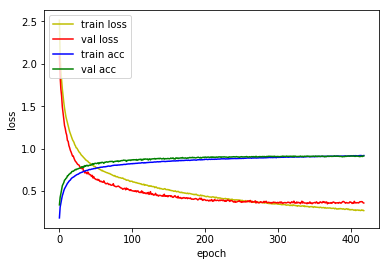

4815/4815 [==============================] - 3s 671us/sample - loss: 0.4066 - acc: 0.8883
Loss: 0.4066322600111164 Accuracy: 0.88826585

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3608 - acc: 0.2212
Epoch 00001: val_loss improved from inf to 1.89358, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_5_conv_checkpoint/001-1.8936.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 2.3608 - acc: 0.2212 - val_loss: 1.8936 - val_acc: 0.4039
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8700 - acc: 0.3845
Epoch 00002: val_loss improved from 1.89358 to 1.58830, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_5_conv_checkpoint/002-1.5883.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 1.8698 - acc: 0.3845 - val_loss: 1.5883 - val_acc: 0.5195
Epoch 3/500
36800/36805 [===========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.6293 - acc: 0.8176
Epoch 00022: val_loss did not improve from 0.48386
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.6293 - acc: 0.8176 - val_loss: 0.5129 - val_acc: 0.8481
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5992 - acc: 0.8256
Epoch 00023: val_loss improved from 0.48386 to 0.48133, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_5_conv_checkpoint/023-0.4813.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.5992 - acc: 0.8256 - val_loss: 0.4813 - val_acc: 0.8719
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5860 - acc: 0.8277
Epoch 00024: val_loss improved from 0.48133 to 0.43750, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_5_conv_checkpoint/024-0.4375.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.5859 - acc: 0.8277 - val_

Epoch 46/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3751 - acc: 0.8893
Epoch 00046: val_loss did not improve from 0.29790
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.3751 - acc: 0.8893 - val_loss: 0.3249 - val_acc: 0.9152
Epoch 47/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3702 - acc: 0.8909
Epoch 00047: val_loss improved from 0.29790 to 0.29079, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_5_conv_checkpoint/047-0.2908.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.3701 - acc: 0.8909 - val_loss: 0.2908 - val_acc: 0.9201
Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3704 - acc: 0.8922
Epoch 00048: val_loss improved from 0.29079 to 0.28586, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_5_conv_checkpoint/048-0.2859.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.3703 - acc: 

Epoch 72/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2699 - acc: 0.9180
Epoch 00072: val_loss did not improve from 0.24810
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2699 - acc: 0.9180 - val_loss: 0.2548 - val_acc: 0.9331
Epoch 73/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2676 - acc: 0.9183
Epoch 00073: val_loss improved from 0.24810 to 0.23770, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_5_conv_checkpoint/073-0.2377.hdf5
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2675 - acc: 0.9184 - val_loss: 0.2377 - val_acc: 0.9380
Epoch 74/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2615 - acc: 0.9196
Epoch 00074: val_loss did not improve from 0.23770
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.2615 - acc: 0.9196 - val_loss: 0.2407 - val_acc: 0.9373
Epoch 75/500
36800/36805 [============================>.] - ETA:

Epoch 100/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2080 - acc: 0.9351
Epoch 00100: val_loss did not improve from 0.22633
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2080 - acc: 0.9351 - val_loss: 0.2324 - val_acc: 0.9415
Epoch 101/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2066 - acc: 0.9353
Epoch 00101: val_loss did not improve from 0.22633
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2067 - acc: 0.9353 - val_loss: 0.2296 - val_acc: 0.9429
Epoch 102/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2005 - acc: 0.9373
Epoch 00102: val_loss did not improve from 0.22633
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.2007 - acc: 0.9373 - val_loss: 0.2270 - val_acc: 0.9404
Epoch 103/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1992 - acc: 0.9372
Epoch 00103: val_loss did not improve from 0.22633
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.1630 - acc: 0.9483
Epoch 00129: val_loss did not improve from 0.21809
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1630 - acc: 0.9483 - val_loss: 0.2397 - val_acc: 0.9441
Epoch 130/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1576 - acc: 0.9496
Epoch 00130: val_loss did not improve from 0.21809
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1576 - acc: 0.9496 - val_loss: 0.2200 - val_acc: 0.9460
Epoch 131/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1561 - acc: 0.9498
Epoch 00131: val_loss did not improve from 0.21809
36805/36805 [==============================] - 63s 2ms/sample - loss: 0.1561 - acc: 0.9498 - val_loss: 0.2255 - val_acc: 0.9420
Epoch 132/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1564 - acc: 0.9505
Epoch 00132: val_loss did not improve from 0.21809
36805/36805 [=====================

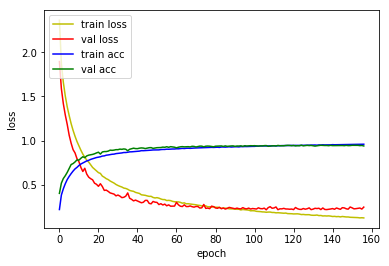

4815/4815 [==============================] - 3s 679us/sample - loss: 0.2629 - acc: 0.9225
Loss: 0.26294008484758197 Accuracy: 0.92253375

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1933 - acc: 0.2710
Epoch 00001: val_loss improved from inf to 1.58756, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_6_conv_checkpoint/001-1.5876.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 2.1932 - acc: 0.2710 - val_loss: 1.5876 - val_acc: 0.5171
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5373 - acc: 0.5049
Epoch 00002: val_loss improved from 1.58756 to 1.23462, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_6_conv_checkpoint/002-1.2346.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.5374 - acc: 0.5049 - val_loss: 1.2346 - val_acc: 0.6427
Epoch 3/500
36800/36805 [==========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2902 - acc: 0.9112
Epoch 00023: val_loss improved from 0.19961 to 0.19643, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_6_conv_checkpoint/023-0.1964.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.2902 - acc: 0.9112 - val_loss: 0.1964 - val_acc: 0.9485
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2843 - acc: 0.9144
Epoch 00024: val_loss did not improve from 0.19643
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.2842 - acc: 0.9144 - val_loss: 0.1988 - val_acc: 0.9464
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2717 - acc: 0.9171
Epoch 00025: val_loss did not improve from 0.19643
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.2717 - acc: 0.9171 - val_loss: 0.2012 - val_acc: 0.9427
Epoch 26/500
36800/36805 [============================>.] - ETA:

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1534 - acc: 0.9516
Epoch 00049: val_loss did not improve from 0.14323
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1534 - acc: 0.9516 - val_loss: 0.1536 - val_acc: 0.9585
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9540
Epoch 00050: val_loss did not improve from 0.14323
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1442 - acc: 0.9540 - val_loss: 0.1567 - val_acc: 0.9562
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9544
Epoch 00051: val_loss did not improve from 0.14323
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1442 - acc: 0.9544 - val_loss: 0.1456 - val_acc: 0.9609
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1406 - acc: 0.9540
Epoch 00052: val_loss did not improve from 0.14323
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0876 - acc: 0.9713
Epoch 00077: val_loss did not improve from 0.13469
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0876 - acc: 0.9713 - val_loss: 0.1399 - val_acc: 0.9648
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9725
Epoch 00078: val_loss did not improve from 0.13469
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0827 - acc: 0.9725 - val_loss: 0.1608 - val_acc: 0.9599
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0808 - acc: 0.9730
Epoch 00079: val_loss did not improve from 0.13469
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0809 - acc: 0.9729 - val_loss: 0.1534 - val_acc: 0.9606
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0824 - acc: 0.9740
Epoch 00080: val_loss did not improve from 0.13469
36805/36805 [========================

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0504 - acc: 0.9832
Epoch 00107: val_loss did not improve from 0.13469
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0503 - acc: 0.9832 - val_loss: 0.1910 - val_acc: 0.9592
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9835
Epoch 00108: val_loss did not improve from 0.13469
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0488 - acc: 0.9835 - val_loss: 0.1742 - val_acc: 0.9630
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9845
Epoch 00109: val_loss did not improve from 0.13469
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0463 - acc: 0.9845 - val_loss: 0.1746 - val_acc: 0.9616
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0505 - acc: 0.9830
Epoch 00110: val_loss did not improve from 0.13469
36805/36805 [=======

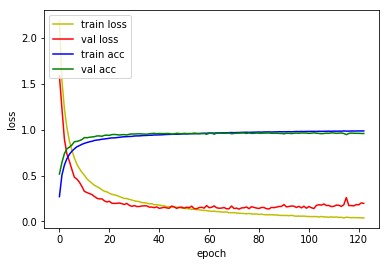

4815/4815 [==============================] - 4s 746us/sample - loss: 0.1704 - acc: 0.9516
Loss: 0.17036764390557727 Accuracy: 0.95160955

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9480 - acc: 0.3663
Epoch 00001: val_loss improved from inf to 1.11162, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_7_conv_checkpoint/001-1.1116.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.9480 - acc: 0.3663 - val_loss: 1.1116 - val_acc: 0.6781
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0536 - acc: 0.6708
Epoch 00002: val_loss improved from 1.11162 to 0.71153, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_7_conv_checkpoint/002-0.7115.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.0536 - acc: 0.6708 - val_loss: 0.7115 - val_acc: 0.7987
Epoch 3/500
36800/36805 [==========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1453 - acc: 0.9541
Epoch 00024: val_loss improved from 0.13654 to 0.13034, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_7_conv_checkpoint/024-0.1303.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1453 - acc: 0.9541 - val_loss: 0.1303 - val_acc: 0.9630
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1397 - acc: 0.9560
Epoch 00025: val_loss improved from 0.13034 to 0.12850, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_7_conv_checkpoint/025-0.1285.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1397 - acc: 0.9560 - val_loss: 0.1285 - val_acc: 0.9609
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9576
Epoch 00026: val_loss did not improve from 0.12850
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.1295 - acc: 0.9576 - val_

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9815
Epoch 00051: val_loss did not improve from 0.12230
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0544 - acc: 0.9815 - val_loss: 0.1343 - val_acc: 0.9665
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0485 - acc: 0.9833
Epoch 00052: val_loss did not improve from 0.12230
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0485 - acc: 0.9833 - val_loss: 0.1382 - val_acc: 0.9646
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9827
Epoch 00053: val_loss did not improve from 0.12230
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0510 - acc: 0.9827 - val_loss: 0.1304 - val_acc: 0.9655
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9826
Epoch 00054: val_loss did not improve from 0.12230
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9916
Epoch 00081: val_loss did not improve from 0.12230
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0267 - acc: 0.9916 - val_loss: 0.1732 - val_acc: 0.9637
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9911
Epoch 00082: val_loss did not improve from 0.12230
36805/36805 [==============================] - 64s 2ms/sample - loss: 0.0271 - acc: 0.9911 - val_loss: 0.1584 - val_acc: 0.9646
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9929
Epoch 00083: val_loss did not improve from 0.12230
36805/36805 [==============================] - 65s 2ms/sample - loss: 0.0237 - acc: 0.9929 - val_loss: 0.1617 - val_acc: 0.9681
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9927
Epoch 00084: val_loss did not improve from 0.12230
36805/36805 [===========

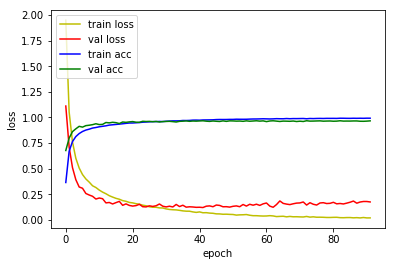

4815/4815 [==============================] - 4s 731us/sample - loss: 0.1606 - acc: 0.9558
Loss: 0.16059520496819496 Accuracy: 0.9557632

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6743 - acc: 0.4588
Epoch 00001: val_loss improved from inf to 0.97354, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_8_conv_checkpoint/001-0.9735.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 1.6742 - acc: 0.4588 - val_loss: 0.9735 - val_acc: 0.6965
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7737 - acc: 0.7549
Epoch 00002: val_loss improved from 0.97354 to 0.52610, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_ch_128_DO_8_conv_checkpoint/002-0.5261.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.7736 - acc: 0.7549 - val_loss: 0.5261 - val_acc: 0.8314
Epoch 3/500
36800/36805 [===========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0698 - acc: 0.9766
Epoch 00025: val_loss did not improve from 0.11677
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0698 - acc: 0.9766 - val_loss: 0.1216 - val_acc: 0.9658
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0673 - acc: 0.9771
Epoch 00026: val_loss did not improve from 0.11677
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0673 - acc: 0.9771 - val_loss: 0.1355 - val_acc: 0.9630
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9777
Epoch 00027: val_loss did not improve from 0.11677
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0651 - acc: 0.9777 - val_loss: 0.1618 - val_acc: 0.9597
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0589 - acc: 0.9798
Epoch 00028: val_loss did not improve from 0.11677
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9921
Epoch 00055: val_loss did not improve from 0.11677
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0244 - acc: 0.9921 - val_loss: 0.1706 - val_acc: 0.9688
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0186 - acc: 0.9940
Epoch 00056: val_loss did not improve from 0.11677
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0186 - acc: 0.9940 - val_loss: 0.1871 - val_acc: 0.9620
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9933
Epoch 00057: val_loss did not improve from 0.11677
36805/36805 [==============================] - 66s 2ms/sample - loss: 0.0217 - acc: 0.9933 - val_loss: 0.1695 - val_acc: 0.9679
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9935
Epoch 00058: val_loss did not improve from 0.11677
36805/36805 [===========

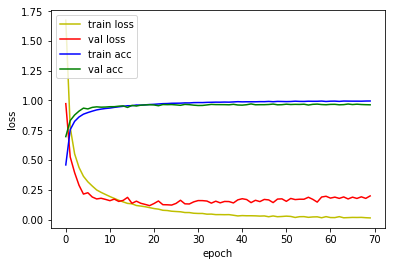

4815/4815 [==============================] - 4s 809us/sample - loss: 0.1962 - acc: 0.9439
Loss: 0.19617292084155735 Accuracy: 0.94392526



In [10]:
base = '1D_CNN_custom_multi_2_GAP_ch_128_DO'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
___________________________________________________________

4815/4815 [==============================] - 4s 782us/sample - loss: 0.2629 - acc: 0.9225
Loss: 0.26294008484758197 Accuracy: 0.92253375

1D_CNN_custom_multi_2_GAP_ch_128_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 128)   768         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 128)   0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (Max

4815/4815 [==============================] - 4s 829us/sample - loss: 0.1606 - acc: 0.9558
Loss: 0.16059520496819496 Accuracy: 0.9557632

1D_CNN_custom_multi_2_GAP_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 128)   768         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 128)   0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxP

In [12]:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_multi_2_GAP_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 128)   768         input_7[0][0]                    
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 128)   0           conv1d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_33 (MaxPooling1D) (None, 5333, 128)    0           activation_33[0][0]              
___________________________________________________________

4815/4815 [==============================] - 4s 834us/sample - loss: 0.2957 - acc: 0.9223
Loss: 0.2957171440248301 Accuracy: 0.9223261

1D_CNN_custom_multi_2_GAP_ch_128_DO_6_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 16000, 128)   768         input_10[0][0]                   
__________________________________________________________________________________________________
activation_45 (Activation)      (None, 16000, 128)   0           conv1d_45[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_45 (MaxPo

4815/4815 [==============================] - 4s 887us/sample - loss: 0.2028 - acc: 0.9585
Loss: 0.2028033662915253 Accuracy: 0.95846313

1D_CNN_custom_multi_2_GAP_ch_128_DO_8_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_58 (Conv1D)              (None, 16000, 128)   768         input_12[0][0]                   
__________________________________________________________________________________________________
activation_58 (Activation)      (None, 16000, 128)   0           conv1d_58[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_58 (MaxP